In [34]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix#, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [7]:
df= pd.read_csv("/content/info_error.csv")

In [8]:
df1= df.copy()

In [9]:
df1

,static_text,log_level,preprocessed_text
0,Ignoring invalid region for server | ; cell=,error,ignor invalid region server
1,Added * regions to meta.,info,ad region meta
2,Updated * in hbase:meta,info,updat hbase meta
3,Deleted table | state from META,info,delet tabl state meta
4,Updated row * with server=,info,updat row
...,...,...,...
7210,not executing watch [*] on this scheduler beca...,info,execut watch schedul paus
7211,SpnegoClient with userPrincipalName : *,info,spnegocli userprincipalnam
7212,"privileged action exception, with root cause",error,privileg action except root caus
7213,SimpleKdcLdapServer started.,info,simplekdcldapserv start


In [10]:
df1['log_level'].value_counts()

info     3903
error    3312
Name: log_level, dtype: int64

In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
df1['preprocessed_text'].fillna('', inplace=True)
df1 = df1.dropna(subset=['preprocessed_text'])

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df1['preprocessed_text'])

In [15]:
# Label encoding
df1['log_level'] = df1['log_level'].map({'info': 0, 'error': 1})
y = df['log_level']

In [16]:
df1

,static_text,log_level,preprocessed_text
0,Ignoring invalid region for server | ; cell=,1,ignor invalid region server
1,Added * regions to meta.,0,ad region meta
2,Updated * in hbase:meta,0,updat hbase meta
3,Deleted table | state from META,0,delet tabl state meta
4,Updated row * with server=,0,updat row
...,...,...,...
7210,not executing watch [*] on this scheduler beca...,0,execut watch schedul paus
7211,SpnegoClient with userPrincipalName : *,0,spnegocli userprincipalnam
7212,"privileged action exception, with root cause",1,privileg action except root caus
7213,SimpleKdcLdapServer started.,0,simplekdcldapserv start


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# Split the data into training (80%), validation (10%), and testing (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print('Train sets:')
print(X_train.shape)
print(y_train.shape)

print('Validation sets:')
print(X_val.shape)
print(y_val.shape)

print('Test sets:')
print(X_test.shape)
print(y_test.shape)

Train sets:
(5772, 2335)
(5772,)
Validation sets:
(721, 2335)
(721,)
Test sets:
(722, 2335)
(722,)


# ***Class-Imabalance***

In [19]:
# Check the distribution of classes before SMOTE
print("Distribution of classes in the original training set:")
print(pd.Series(y_train).value_counts())

Distribution of classes in the original training set:
info     3152
error    2620
Name: log_level, dtype: int64


In [20]:
# Apply SMOTE for balancing
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [21]:
# Check the distribution of classes after SMOTE
print("Distribution of classes in the training set after SMOTEENN:")
print(pd.Series(y_resampled).value_counts())

Distribution of classes in the training set after SMOTEENN:
info     3152
error    3152
Name: log_level, dtype: int64


# ***Hyper-parameter tunning***

In [22]:
# Hyper-parameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

## **Model: RF**

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
model=RandomForestClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)
# Get the best parameters from the grid search
best_params = grid_search.best_params_
#model.fit(X_resampled, y_resampled)


In [25]:
# Train the model with the best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_resampled, y_resampled)

RandomForestClassifier(n_estimators=50, random_state=42)

Validation Set Results:
Accuracy: 0.9001386962552012
              precision    recall  f1-score   support

       error       0.89      0.91      0.90       349
        info       0.91      0.89      0.90       372

    accuracy                           0.90       721
   macro avg       0.90      0.90      0.90       721
weighted avg       0.90      0.90      0.90       721

MCC: 0.800412748615692
[[317  32]
 [ 40 332]]


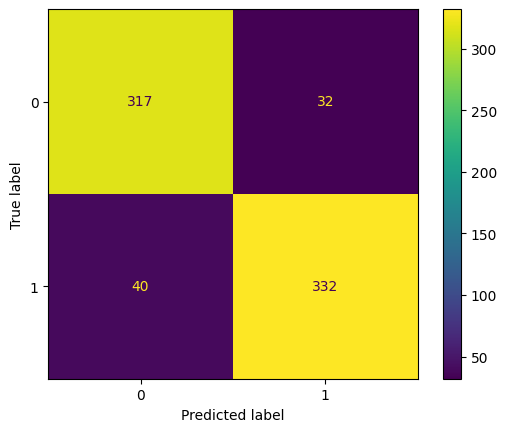

In [26]:
# Evaluate the model on the validation set
y_val_pred = best_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
report_val = classification_report(y_val, y_val_pred)
mcc_val = matthews_corrcoef(y_val, y_val_pred)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)

print("Validation Set Results:")
print(f"Accuracy: {accuracy_val}")
print(report_val)
print(f"MCC: {mcc_val}")
print(conf_matrix_val)

import matplotlib.pyplot as plt
cm = confusion_matrix(y_val, y_val_pred)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()

Test Set Results:
Accuracy: 0.8822714681440443
              precision    recall  f1-score   support

       error       0.86      0.90      0.88       343
        info       0.91      0.87      0.89       379

    accuracy                           0.88       722
   macro avg       0.88      0.88      0.88       722
weighted avg       0.88      0.88      0.88       722

MCC: 0.7653597474204654
[[309  34]
 [ 51 328]]


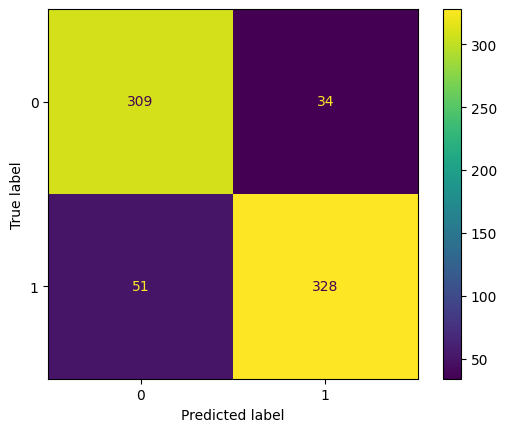

In [32]:
# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
report_test = classification_report(y_test, y_test_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
conf_matrix_val = confusion_matrix(y_test, y_test_pred)


print("Test Set Results:")
print(f"Accuracy: {accuracy_test}")
print(report_test)
print(f"MCC: {mcc_test}")
print(conf_matrix_val)

import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_test_pred)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()

In [37]:
# Random Forest Model
print("Random Forest Model Results:")
y_rf_pred = best_model.predict(X_test)
incorrect_rf_indices = y_test != y_rf_pred
correct_rf_indices = y_test == y_rf_pred

incorrect_rf_texts = df1.loc[y_test.index[incorrect_rf_indices], 'preprocessed_text']
true_rf_labels = y_test[incorrect_rf_indices]
predicted_rf_labels = y_rf_pred[incorrect_rf_indices]

print("\nRecords where Random Forest model failed to predict the labels:")
for idx, text, true_label, pred_label in zip(incorrect_rf_texts.index, incorrect_rf_texts, true_rf_labels, predicted_rf_labels):
    print(f"Index: {idx}, Text: {text}, True Label: {true_label}, Predicted Label: {pred_label}")

Random Forest Model Results:

Records where Random Forest model failed to predict the labels:
Index: 6811, Text: determin current memori usag due, True Label: info, Predicted Label: error
Index: 1373, Text: send interrupt stop worker thread, True Label: info, Predicted Label: error
Index: 705, Text: empti messag, True Label: info, Predicted Label: error
Index: 1172, Text: creat null, True Label: info, Predicted Label: error
Index: 5230, Text: fail commit recoveri mpu id check file commit, True Label: info, Predicted Label: error
Index: 4712, Text: blob server stop work shut, True Label: error, Predicted Label: info
Index: 3499, Text: interrupt wait task termin, True Label: error, Predicted Label: info
Index: 3091, Text: encod file contain illeg charact, True Label: error, Predicted Label: info
Index: 3866, Text: empti messag, True Label: info, Predicted Label: error
Index: 1805, Text: store file compact may due regionserv awar store file reattempt compact, True Label: error, Predicted 

In [ ]:
    # Identify indices where predictions are incorrect
    incorrect_indices = y_test != y_test_pred

    # Extract the original texts and corresponding true labels
    incorrect_texts = df.loc[y_test.index[incorrect_indices], 'preprocessed_text']
    true_labels = y_test[incorrect_indices]
    predicted_labels = y_test_pred[incorrect_indices]

    # Print the records where the model failed to predict the labels
    print(f"\nRecords where {model_name} failed to predict labels:")
    for idx, text, true_label, pred_label in zip(incorrect_texts.index, incorrect_texts, true_labels, predicted_labels):
        print(f"Index: {idx}")
        print(f"True Labels: {true_label}")
        print(f"Predicted Labels: {pred_label}")
        print(f"Text: {text}\n")

In [38]:
correct_rf_texts = df1.loc[y_test.index[correct_rf_indices], 'preprocessed_text']
correct_true_rf_labels = y_test[correct_rf_indices]
correct_predicted_rf_labels = y_rf_pred[correct_rf_indices]

print("\nRecords where Random Forest model predicted the labels correctly:")
for idx, text, true_label, pred_label in zip(correct_rf_texts.index, correct_rf_texts, correct_true_rf_labels, correct_predicted_rf_labels):
    print(f"Index: {idx}, Text: {text}, True Label: {true_label}, Predicted Label: {pred_label}")


Records where Random Forest model predicted the labels correctly:
Index: 1662, Text: error abl write region move output file move region, True Label: error, Predicted Label: error
Index: 549, Text: initi rsgroup info retriev, True Label: info, Predicted Label: info
Index: 6060, Text: start coordin process, True Label: info, Predicted Label: info
Index: 1480, Text: find path, True Label: error, Predicted Label: error
Index: 2726, Text: bound rmi registri port, True Label: info, Predicted Label: info
Index: 1545, Text: fail write, True Label: error, Predicted Label: error
Index: 5327, Text: recurs hash join partit number, True Label: info, Predicted Label: info
Index: 2523, Text: interrupt, True Label: info, Predicted Label: info
Index: 4377, Text: fail elasticsearch bulk request, True Label: error, Predicted Label: error
Index: 5610, Text: empti messag, True Label: error, Predicted Label: error
Index: 1775, Text: patch hbase meta, True Label: info, Predicted Label: info
Index: 2955, Te

In [53]:
    # Identify indices where predictions are incorrect
    incorrect_indices = y_test != y_test_pred

    # Extract the original texts and corresponding true labels
    incorrect_texts = df.loc[y_test.index[incorrect_indices], 'preprocessed_text']
    true_labels = y_test[incorrect_indices]
    predicted_labels = y_test_pred[incorrect_indices]

    # Print the records where the model failed to predict the labels
    print(f"\nRecords where {best_model} failed to predict labels:")
    for idx, text, true_label, pred_label in zip(incorrect_texts.index, incorrect_texts, true_labels, predicted_labels):
        print(f"Index: {idx}")
        print(f"True Labels: {true_label}")
        print(f"Predicted Labels: {pred_label}")
        print(f"Text: {text}\n")


Records where RandomForestClassifier(n_estimators=50, random_state=42) failed to predict labels:
Index: 6811
True Labels: info
Predicted Labels: error
Text: determin current memori usag due

Index: 1373
True Labels: info
Predicted Labels: error
Text: send interrupt stop worker thread

Index: 1480
True Labels: error
Predicted Labels: info
Text: find path

Index: 705
True Labels: info
Predicted Labels: error
Text: empti messag

Index: 1172
True Labels: info
Predicted Labels: error
Text: creat null

Index: 5230
True Labels: info
Predicted Labels: error
Text: fail commit recoveri mpu id check file commit

Index: 1803
True Labels: info
Predicted Labels: error
Text: famili specifi execut famili

Index: 4712
True Labels: error
Predicted Labels: info
Text: blob server stop work shut

Index: 3866
True Labels: info
Predicted Labels: error
Text: empti messag

Index: 1805
True Labels: error
Predicted Labels: info
Text: store file compact may due regionserv awar store file reattempt compact

Index

In [54]:
# Identify indices where predictions are correct
correct_indices = y_test == y_test_pred

# Extract the original texts and corresponding true labels
correct_texts = df1.loc[y_test.index[correct_indices], 'preprocessed_text']
correct_true_labels = y_test[correct_indices]
correct_predicted_labels = y_test_pred[correct_indices]

# Print the records where the model predicted the labels correctly
print(f"\nRecords where {best_model} predicted labels correctly:")
for idx, text, true_label, pred_label in zip(correct_texts.index, correct_texts, correct_true_labels, correct_predicted_labels):
    print(f"Index: {idx}")
    print(f"True Labels: {true_label}")
    print(f"Predicted Labels: {pred_label}")
    print(f"Text: {text}\n")


Records where RandomForestClassifier(n_estimators=50, random_state=42) predicted labels correctly:
Index: 1662
True Labels: error
Predicted Labels: error
Text: error abl write region move output file move region

Index: 549
True Labels: info
Predicted Labels: info
Text: initi rsgroup info retriev

Index: 6060
True Labels: info
Predicted Labels: info
Text: start coordin process

Index: 2726
True Labels: info
Predicted Labels: info
Text: bound rmi registri port

Index: 1545
True Labels: error
Predicted Labels: error
Text: fail write

Index: 5327
True Labels: info
Predicted Labels: info
Text: recurs hash join partit number

Index: 2523
True Labels: info
Predicted Labels: info
Text: interrupt

Index: 4377
True Labels: error
Predicted Labels: error
Text: fail elasticsearch bulk request

Index: 5610
True Labels: error
Predicted Labels: error
Text: empti messag

Index: 1775
True Labels: info
Predicted Labels: info
Text: patch hbase meta

Index: 2955
True Labels: error
Predicted Labels: error

done
done
['info' 'info' 'info' 'info' 'info' 'info' 'info' 'info' 'info']
Accuracy: 0.44
Precision: 0.44
Recall: 1.00
F1 Score: 0.62
Confusion Matrix:
[[0 5]
 [0 4]]


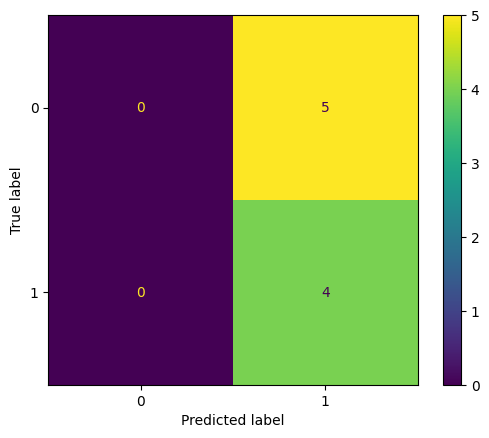

In [39]:
#Using RF

#This need tobe edited for we and  wi


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix#, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Referred to https://learn.microsoft.com/en-us/previous-versions/windows/desktop/bb226812(v=vs.85) to construct representative log messages.
messages = ["Unused variable 'unused_variable", "This function is deprecated, use new_function instead","Near memory limit", "Program crashed when loading file", "Division by zero is undefined", "Unused import 'unused_function'", "File Transfer Complete", "File loaded", "missing parentheses in call to 'example_function'"]
#The codding for the log messages is: {INFO: 0, Warn:1}.
true_labels = [0,0,1,1,0,0,1,1,0]

#Feature extraction using TF-IDF
message_Vect = tfidf_vectorizer.transform(messages)
print('done')
predicted_labels = best_model.predict(message_Vect)
predicted_lables_bin = []
for i in predicted_labels:
    if i=='info':
        predicted_lables_bin.append(1)
    else:
        predicted_lables_bin.append(0)

print('done')
#Calculates accuracy
accuracy = accuracy_score(true_labels,predicted_lables_bin)
print(predicted_labels)
#Calculate precision, recall, and F1 score
precision = precision_score(true_labels,predicted_lables_bin)
recall = recall_score(true_labels, predicted_lables_bin)
f1 = f1_score(true_labels, predicted_lables_bin)

#Calculate confusion matrix
confusion = confusion_matrix(true_labels, predicted_lables_bin)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

import matplotlib.pyplot as plt
cm = confusion_matrix(true_labels, predicted_lables_bin)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()

## **Model: SVM**

In [40]:
from sklearn.svm import SVC

In [41]:
# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 25],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

In [42]:
model1 = SVC(probability=True)
grid_search = GridSearchCV(estimator=model1, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)
# Get the best parameters from the grid search
best_params = grid_search.best_params_

#model.fit(X_resampled, y_resampled)
#model1.fit(X_train, y_train)

In [43]:
# Train the model with the best hyperparameters
best_model1 = SVC(probability=True,**best_params)
best_model1.fit(X_resampled, y_resampled)

SVC(C=25, gamma=1, probability=True)

Validation Set Results:
Accuracy: 0.8876560332871013
MCC: 0.7751698215451829
Confusion Matrix:
 [[310  39]
 [ 42 330]]
              precision    recall  f1-score   support

       error       0.88      0.89      0.88       349
        info       0.89      0.89      0.89       372

    accuracy                           0.89       721
   macro avg       0.89      0.89      0.89       721
weighted avg       0.89      0.89      0.89       721



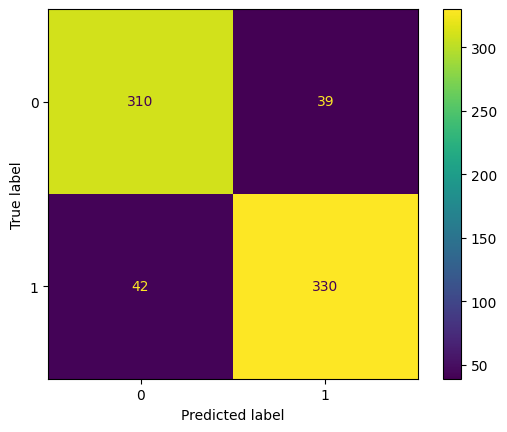

In [44]:
# Evaluate the SVM model on the validation set
y_val_pred = best_model1.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
mcc_val = matthews_corrcoef(y_val, y_val_pred)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
report_val = classification_report(y_val, y_val_pred)

print("Validation Set Results:")
print(f"Accuracy: {accuracy_val}")
print(f"MCC: {mcc_val}")
print("Confusion Matrix:\n", conf_matrix_val)
print(report_val)


import matplotlib.pyplot as plt
cm = confusion_matrix(y_val, y_val_pred)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()

Test Set Results:
Accuracy: 0.8781163434903048
MCC: 0.7566677854161022
Confusion Matrix:
 [[306  37]
 [ 51 328]]
              precision    recall  f1-score   support

       error       0.86      0.89      0.87       343
        info       0.90      0.87      0.88       379

    accuracy                           0.88       722
   macro avg       0.88      0.88      0.88       722
weighted avg       0.88      0.88      0.88       722



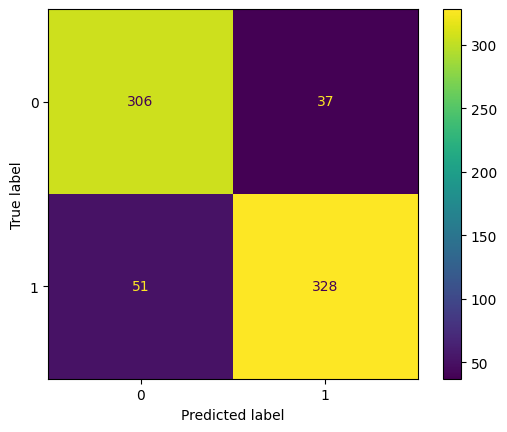

In [45]:
# Evaluate the SVM model on the test set
y_test_pred = best_model1.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
report_test = classification_report(y_test, y_test_pred)

print("Test Set Results:")
print(f"Accuracy: {accuracy_test}")
print(f"MCC: {mcc_test}")
print("Confusion Matrix:\n", conf_matrix_test)
print(report_test)

import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_test_pred)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()

In [46]:
print("\nSVM Model Results:")
y_svm_pred = best_model1.predict(X_test)
incorrect_svm_indices = y_test != y_svm_pred
correct_svm_indices = y_test == y_svm_pred


SVM Model Results:


In [59]:
incorrect_svm_texts = df1.loc[y_test.index[incorrect_svm_indices], 'preprocessed_text']
true_svm_labels = y_test[incorrect_svm_indices]
predicted_svm_labels = y_svm_pred[incorrect_svm_indices]

print("\nRecords where svm model failed to predict the labels:")
for idx, text, true_label, pred_label in zip(incorrect_svm_texts.index, incorrect_svm_texts, true_svm_labels, predicted_svm_labels):
    #print(f"Index: {idx}, Text: {text}, True Label: {true_label}, Predicted Label: {pred_label}")
    print(f"Index: {idx}")
    print(f"True Labels: {true_label}")
    print(f"Predicted Labels: {pred_label}")
    print(f"Text: {text}\n")


Records where svm model failed to predict the labels:
Index: 6811
True Labels: info
Predicted Labels: error
Text: determin current memori usag due

Index: 1373
True Labels: info
Predicted Labels: error
Text: send interrupt stop worker thread

Index: 1480
True Labels: error
Predicted Labels: info
Text: find path

Index: 705
True Labels: info
Predicted Labels: error
Text: empti messag

Index: 1172
True Labels: info
Predicted Labels: error
Text: creat null

Index: 5230
True Labels: info
Predicted Labels: error
Text: fail commit recoveri mpu id check file commit

Index: 1803
True Labels: info
Predicted Labels: error
Text: famili specifi execut famili

Index: 4712
True Labels: error
Predicted Labels: info
Text: blob server stop work shut

Index: 3866
True Labels: info
Predicted Labels: error
Text: empti messag

Index: 1805
True Labels: error
Predicted Labels: info
Text: store file compact may due regionserv awar store file reattempt compact

Index: 248
True Labels: info
Predicted Labels: e

In [49]:

correct_svm_texts = df1.loc[y_test.index[correct_svm_indices], 'preprocessed_text']
correct_true_svm_labels = y_test[correct_svm_indices]
correct_predicted_svm_labels = y_rf_pred[correct_svm_indices]

In [57]:
print("\nRecords where svm model failed to predict the labels:")
for idx, text, true_label, pred_label in zip(incorrect_svm_texts.index, incorrect_svm_texts, true_svm_labels, predicted_svm_labels):
   # print(f"Index: {idx}, Text: {text}, True Label: {true_label}, Predicted Label: {pred_label}")
    print(f"Index: {idx}")
    print(f"True Labels: {true_label}")
    print(f"Predicted Labels: {pred_label}")
    print(f"Text: {text}\n")


Records where svm model failed to predict the labels:
Index: 6811
True Labels: info
Predicted Labels: error
Text: determin current memori usag due

Index: 1373
True Labels: info
Predicted Labels: error
Text: send interrupt stop worker thread

Index: 1480
True Labels: error
Predicted Labels: info
Text: find path

Index: 705
True Labels: info
Predicted Labels: error
Text: empti messag

Index: 1172
True Labels: info
Predicted Labels: error
Text: creat null

Index: 5230
True Labels: info
Predicted Labels: error
Text: fail commit recoveri mpu id check file commit

Index: 1803
True Labels: info
Predicted Labels: error
Text: famili specifi execut famili

Index: 4712
True Labels: error
Predicted Labels: info
Text: blob server stop work shut

Index: 3866
True Labels: info
Predicted Labels: error
Text: empti messag

Index: 1805
True Labels: error
Predicted Labels: info
Text: store file compact may due regionserv awar store file reattempt compact

Index: 248
True Labels: info
Predicted Labels: e

done
done
['info' 'info' 'error' 'info' 'info' 'info' 'info' 'info' 'info']
Accuracy: 0.33
Precision: 0.38
Recall: 0.75
F1 Score: 0.50
Confusion Matrix:
[[0 5]
 [1 3]]


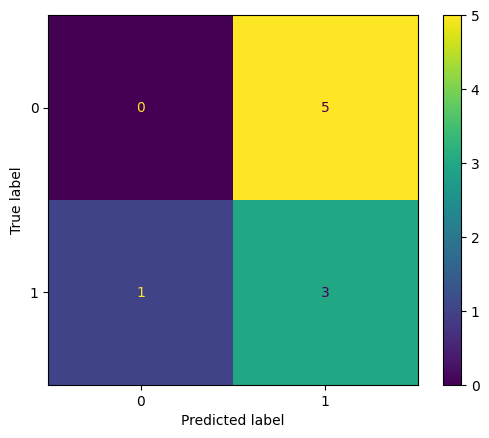

In [51]:
# Using SVM


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix#, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Referred to https://learn.microsoft.com/en-us/previous-versions/windows/desktop/bb226812(v=vs.85) to construct representative log messages.
messages = ["Unused variable 'unused_variable", "This function is deprecated, use new_function instead","Near memory limit", "Program crashed when loading file", "Division by zero is undefined", "Unused import 'unused_function'", "File Transfer Complete", "File loaded", "missing parentheses in call to 'example_function'"]
#The codding for the log messages is: {INFO: 1, ERROR:0}.
true_labels = [0,0,1,1,0,0,1,1,0]

#Feature extraction using TF-IDF
message_Vect = tfidf_vectorizer.transform(messages)
print('done')
predicted_labels = best_model1.predict(message_Vect)
predicted_lables_bin = []
for i in predicted_labels:
    if i=='info':
        predicted_lables_bin.append(1)
    else:
        predicted_lables_bin.append(0)

print('done')
#Calculates accuracy
accuracy = accuracy_score(true_labels,predicted_lables_bin)
print(predicted_labels)
#Calculate precision, recall, and F1 score
precision = precision_score(true_labels,predicted_lables_bin)
recall = recall_score(true_labels, predicted_lables_bin)
f1 = f1_score(true_labels, predicted_lables_bin)

#Calculate confusion matrix
confusion = confusion_matrix(true_labels, predicted_lables_bin)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

import matplotlib.pyplot as plt
cm = confusion_matrix(true_labels, predicted_lables_bin)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()